# Project CV - 1. Image Classification

## VGG16 모델을 사용해서 이미지 분류
`VGG16`
- Image classification task에 자주 사용하는 대표 모델
  - VGG16 논문 : [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/pdf/1409.1556.pdf)


## 🐕개와 🐈‍⬛고양이를 분류하기
- label : 개=1, 고양이=0   

문제 1. VGG16 모델 구현   
- batch normalization, parameter initialization 등을 사용   

문제 2. 다양한 방법을 사용해서 모델 성능 높이기   
- 성능지표 : **accuracy** 
- skip connection, pre-trained model 등 다양한 방법 사용

---
### 데이터 불러오기

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 변수명 앞의 `_`는 내부 사용 전용을 의미
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
path = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

68616192/68606236 [==============================] - 0s 0us/step


In [3]:
# train, validation 데이터에서 개, 고양이 이미지가 저장된 경로를 변수로 저장
train_dir = os.path.join(path, 'train')
validation_dir = os.path.join(path, 'validation')
print(train_dir)
print(validation_dir)

/aiffel/.keras/datasets/cats_and_dogs_filtered/train
/aiffel/.keras/datasets/cats_and_dogs_filtered/validation


In [4]:
# directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats') 
print(train_cats_dir)

# directory with our training dog pictures 
train_dogs_dir = os.path.join(train_dir, 'dogs')  
print(train_dogs_dir)

# directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  
print(validation_cats_dir)

# directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  
print(validation_dogs_dir)

/aiffel/.keras/datasets/cats_and_dogs_filtered/train/cats
/aiffel/.keras/datasets/cats_and_dogs_filtered/train/dogs
/aiffel/.keras/datasets/cats_and_dogs_filtered/validation/cats
/aiffel/.keras/datasets/cats_and_dogs_filtered/validation/dogs


- 데이터가 .keras폴더의 datasets 폴더에 각각 저장되었다. 

In [5]:
# train, validation data 개수 확인
num_cats_tr = len(os.listdir(train_cats_dir))
print('total training cat images:', num_cats_tr)

num_dogs_tr = len(os.listdir(train_dogs_dir))
print('total training dog images:', num_dogs_tr)

print("--")

num_cats_val = len(os.listdir(validation_cats_dir))
print('total validation cat images:', num_cats_val)
num_dogs_val = len(os.listdir(validation_dogs_dir))
print('total validation dog images:', num_dogs_val)

print("--")

total_train = num_cats_tr + num_dogs_tr
print("Total training images:", total_train)
total_val = num_cats_val + num_dogs_val
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
--
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [6]:
# Parameter Initialization
batch_size = 16
epochs = 5
IMG_HEIGHT = 256
IMG_WIDTH = 256

- 왜 `IMG_HEIGHT`, `IMG_WIDTH`만 대문자로 변수명을 지정했을까?

In [7]:
# 데이터를 시각화하기 위한 함수
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

### Data Augmentation
- Train 데이터가 2천장밖에 되지 않기 때문에 `Data augmentation`을 진행

In [8]:
# Training data generator
image_gen_train = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=0.3,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False
)

- `.flow_from_directory` 를 사용해서 파이프라인을 만들고 directory와 작업환경을 연결시킴
- 개와 고양이를 분류하는 task를 수행하니까 `class_mode`는 `binary`
  - classification task에 따라 `class_mode`를 변경

In [9]:
# flow_from_directory로 파이프라인생성, directory와 연결
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                    directory=train_dir,
                                                    shuffle=True,
                                                    target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                    class_mode='binary')

Found 2000 images belonging to 2 classes.


In [10]:
# Data augmentation 확인
# 첫번째 데이터 확인
train_data_gen[0][0].shape

(16, 256, 256, 3)

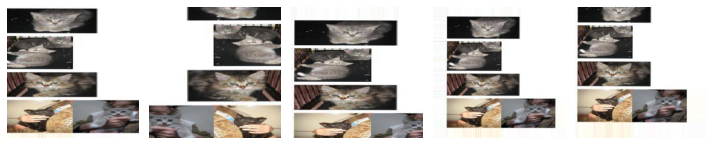

In [11]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [12]:
# validation data augmentation - 분류를 검증하는 용도이기때문에 스케일만 변경
# validation data generator
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                directory=validation_dir,
                                                target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                class_mode='binary')

Found 1000 images belonging to 2 classes.


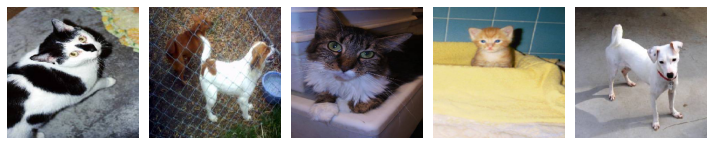

In [13]:
# validation data 확인
sample_training_images, _  = next(val_data_gen) # next() : iterator의 다음 item을 return하는 함수
plotImages(sample_training_images[:5])

[참고] [`_` 사용 관련 참고 블로그](https://eine.tistory.com/entry/%ED%8C%8C%EC%9D%B4%EC%8D%AC%EC%97%90%EC%84%9C-%EC%96%B8%EB%8D%94%EB%B0%94%EC%96%B8%EB%8D%94%EC%8A%A4%EC%BD%94%EC%96%B4-%EC%9D%98-%EC%9D%98%EB%AF%B8%EC%99%80-%EC%97%AD%ED%95%A0)

In [14]:
# 정답 label
_[:5]

array([0., 1., 0., 0., 1.], dtype=float32)

- 개는 1, 고양이는 0 label을 갖고 있다
---

## 문제 1-1. VGG16 모델 구현
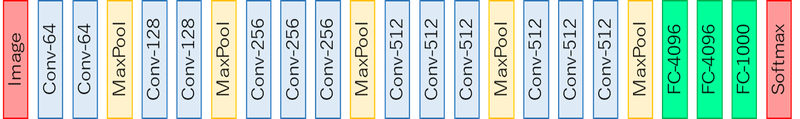

In [15]:
# 편의를 위해 라이브러리 import
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Flatten, Dense

# VGG16 ver.1 - lms 제시 모델
input_layer=Input(shape=(256, 256, 3))
x=Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(input_layer)
x=Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
x=BatchNormalization()(x)
x=MaxPool2D((2, 2))(x)

x=Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
x=Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
x=BatchNormalization()(x)
x=MaxPool2D((2, 2))(x)

x=Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
x=Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
x=Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
x=BatchNormalization()(x)
x=MaxPool2D((2, 2))(x)

x=Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=BatchNormalization()(x)
x=MaxPool2D((2, 2))(x)

x=Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x)
x=BatchNormalization()(x)
x=MaxPool2D((2, 2))(x)

x=Flatten()(x)
x=Dense(4096, activation='relu')(x)
x=Dense(4096, activation='relu')(x)
x=Dense(1000, activation='relu')(x)
out_layer=Dense(1, activation='sigmoid')(x) # 이미지에는 softmax로 되어있지만 이진분류이기때문에 sigmoid사용

model = Model(inputs=[input_layer], outputs=[out_layer])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 128)     147584

- (일부러 이렇게 만들도록 한것 같지만) 데이터 양에 비해 계산해야하는 파라미터의 수가 엄청나다.
- 일단 의도한것 같아서 이대로 훈련을 진행해보고, 이후에 정확도를 높이는 과정에서 모델을 수정하기로 한다

In [16]:
# model compile
loss_function=tf.keras.losses.binary_crossentropy
optimize=tf.keras.optimizers.Adam(learning_rate=0.01)
metric=tf.keras.metrics.binary_accuracy
model.compile(loss=loss_function,
              optimizer=optimize,
              metrics=[metric])

# early stopping 설정
from tensorflow.keras import callbacks
early_stopping_cb = callbacks.EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)

In [17]:
history = model.fit(
      train_data_gen,
      steps_per_epoch=(len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))/batch_size,
      epochs=epochs,
      validation_data=val_data_gen,
      callbacks=[early_stopping_cb],
      validation_freq=1)

Epoch 1/5
125/125 [==============================] - 90s 344ms/step - loss: 619.7190 - binary_accuracy: 0.5235 - val_loss: 1.7060 - val_binary_accuracy: 0.4900
Epoch 2/5
125/125 [==============================] - 42s 330ms/step - loss: 1.3930 - binary_accuracy: 0.5265 - val_loss: 286.3486 - val_binary_accuracy: 0.4900
Epoch 3/5
125/125 [==============================] - 42s 331ms/step - loss: 0.6953 - binary_accuracy: 0.5170 - val_loss: 0.7300 - val_binary_accuracy: 0.5010
Epoch 4/5
125/125 [==============================] - 41s 330ms/step - loss: 0.6972 - binary_accuracy: 0.5010 - val_loss: 0.6932 - val_binary_accuracy: 0.5000
Epoch 5/5
125/125 [==============================] - 42s 332ms/step - loss: 0.6929 - binary_accuracy: 0.5105 - val_loss: 0.6937 - val_binary_accuracy: 0.5000


- 엄청난 학습속도다. 배치사이즈를 훨씬 크게 하거나 층의 깊이를 좀더 얕게 하고, 파라미터 수를 조절할 필요가 있다!

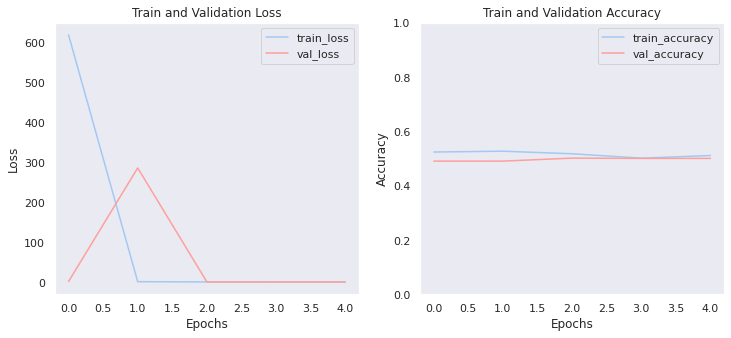

In [48]:
# 학습결과 시각화
import seaborn as sns
sns.set_theme(style='darkgrid', palette='pastel')

# history 1개 보여주는 그래프
def show_history(history):
    history_dict = history.history
    
    accuracy = history_dict['binary_accuracy']
    val_accuracy = history_dict['val_binary_accuracy']
    
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    
    epochs = range(len(accuracy))
    fig = plt.figure(figsize=(12, 5))
    
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(epochs, loss, 'b-', label='train_loss')
    ax1.plot(epochs, val_loss, 'r-', label='val_loss')
    ax1.set_title('Train and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.grid()
    ax1.legend()
    
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(epochs, accuracy, 'b-', label='train_accuracy')
    ax2.plot(epochs, val_accuracy, 'r-', label='val_accuracy')

    ax2.set_ylim(0, 1)
    ax2.set_title('Train and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.grid()
    ax2.legend()
    
    plt.show()

show_history(history)

- loss 값은 거의 0으로 줄었지만 학습이 거의 진행되지 않았다.

---
## 문제 1-2. 다양한 방법을 사용하여 모델의 성능 올리기
- **Pre-trained model** 사용
- 데이터 양이 많지 않으니 미리 학습한 모델의 파라미터값을 사용해서 특성을 추출하고, 분류작업만 직접 학습하면서 진행한다

[참고 블로그](https://blog.naver.com/PostView.naver?blogId=syg7949&logNo=221886870386&parentCategoryNo=27&categoryNo=41&viewDate=&isShowPopularPosts=false&from=thumbnailList)
- '케라스 창시자에게 배우는 딥러닝' 책을 바탕으로 작성된 블로그
- VGG16 모델을 불러와서 Data augmentation을 진행하면서 피처맵을 만들고, 예측하는 방식

---

👉 Keras Applications 에서 제공하는 VGG16 모델 사용 [link](https://keras.io/applications/#vgg16)
- ImageNet에 pretrained된 모델을 활용해서 학습

In [19]:
# pre-trained VGG16 불러오기
from tensorflow import keras

conv_base = keras.applications.vgg16.VGG16(
    weights='imagenet',     # 모델을 초기화할 가중치 체크포인트 지정 : imagenet에 저장된 가중치를 사용
    include_top=False,      # 네트워크 맨 위에 놓인 Dense 분류기 포함여부 : Dense 분류기는 직접 구현할거니까 False
    input_shape=(180,180,3) # input 텐서 크기 -> 잊지않고 아래에서 input shape을 수정!(현재는 256x256) 
)
conv_base.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 180, 180, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 180, 180, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 90, 90, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 90, 90, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 90, 90, 128)       147584    
______________________________________________________________

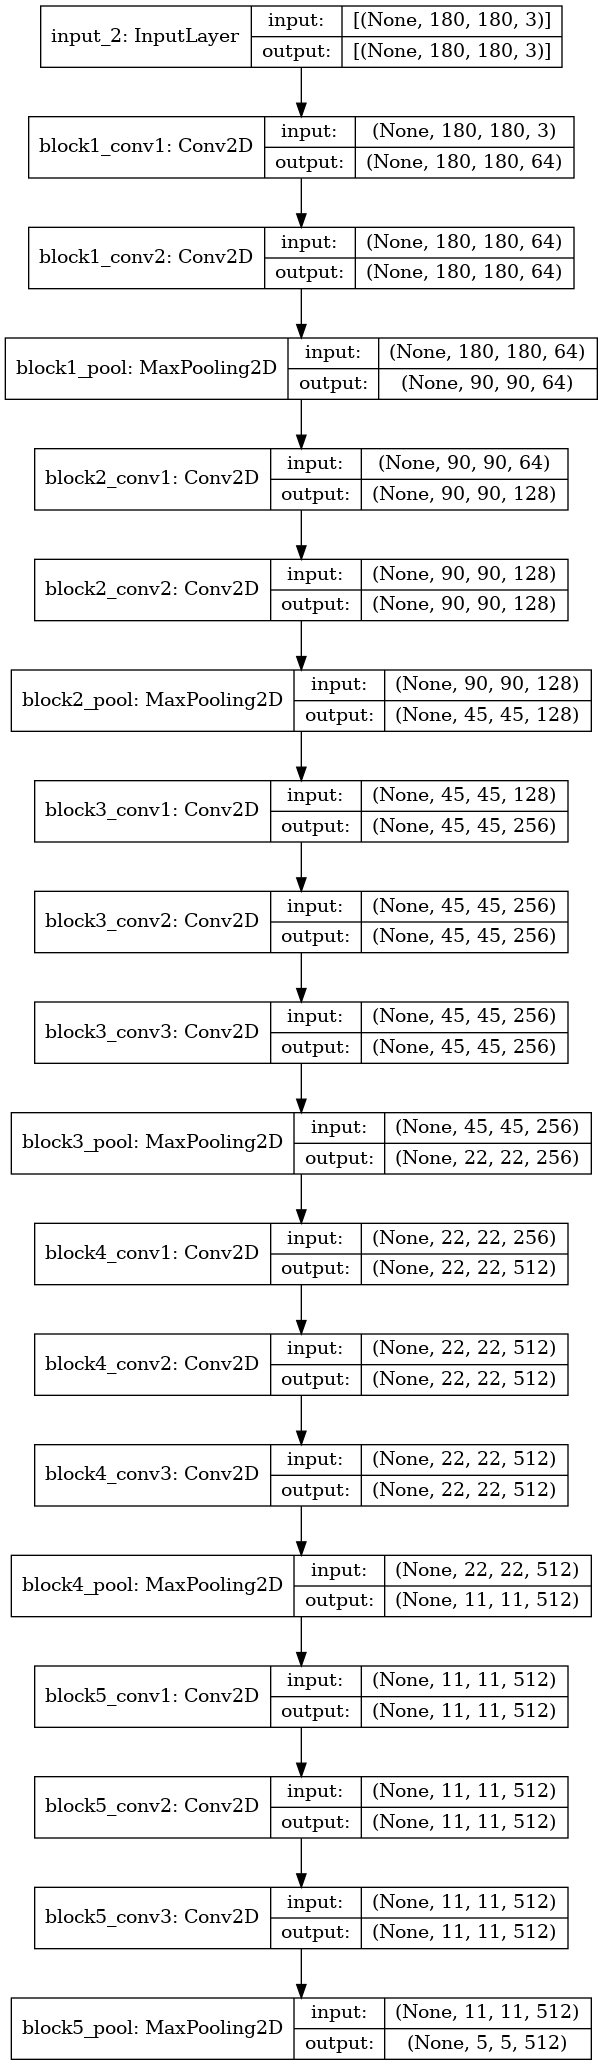

In [21]:
# plot_model로 시각화
from tensorflow.keras.utils import plot_model

# visuatlize model structure
plot_model(conv_base, show_shapes=True)

- Dense layer(분류기)는 빠진 convolutional layer만 잘 들어있는것 확인

### Feature extraction with pretrained VGG16
- convolution layer freeze
    - 가중치가 없데이트 되지 않도록 한다
- 아래의 3개 과정을 연결   
    1. Data augmentation
    2. Freezed convolution layer
    3. Dense layer(classification)
    
---
**1. Data augmentation**

In [22]:
# Parameter Initialization
batch_size = 32   # 이전 값 : 16
epochs = 20       # 이전 값 : 5
IMG_HEIGHT = 180  # 이전 값 : 256
IMG_WIDTH = 180   # 이전 값 : 256

Found 2000 images belonging to 2 classes.


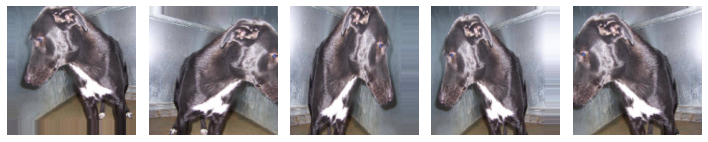

In [23]:
# train data augmentation 2
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                    directory=train_dir,
                                                    shuffle=True,
                                                    target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                    class_mode='binary')
# Data augmentation 확인
# 첫번째 데이터 확인
train_data_gen[0][0].shape
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [24]:
# validation data augmentation
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                directory=validation_dir,
                                                target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                class_mode='binary')

Found 1000 images belonging to 2 classes.


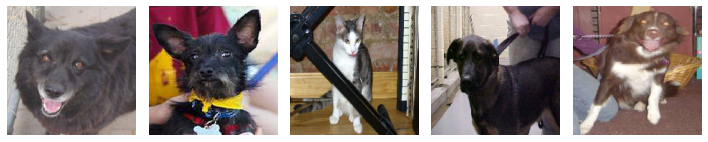

array([1., 1., 0., 1., 1.], dtype=float32)

In [25]:
# validation data 확인
sample_training_images, _  = next(val_data_gen) # next() : iterator의 다음 item을 return하는 함수
plotImages(sample_training_images[:5])
# 정답 label
_[:5]

---
**2. Freezed convolution layer**

In [26]:
# VGG16 convolution layer + freeze
conv_base = keras.applications.vgg16.VGG16(
    weights='imagenet',
    include_top=False
)

conv_base.trainable = False   # 파라미터학습을 새로 하지 않을거기때문에 False로 설정(모델이 갖고있는 파라미터를 활용)
len(conv_base.trainable_weights) # 학습할 파라미터(가중치)수 확인

0

---
**3. layer들 연결**

In [39]:
# data augmentation + convolution layer + Dense layer
from tensorflow.keras.layers import Dropout
'''
VGG16 ver.2
: Feature extraction using pretrained VGG16 + Classification 
'''
input_layer=Input(shape=(180, 180, 3))
x = conv_base(input_layer)          # freezed convolution layer - feature extraction
x = Flatten()(x)   # classification
x = Dense(256)(x)
x = Dropout(0.5)(x)
out_layer = Dense(1, activation='sigmoid')(x)  # sigmoid activation function 사용

model = Model(inputs=[input_layer], outputs=[out_layer])
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               3277056   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 17,992,001
Trainable params: 3,277,313
Non-trainable params: 14,714,688
_______________________________________

In [40]:
# model compile
loss_function=tf.keras.losses.binary_crossentropy
optimize=tf.keras.optimizers.RMSprop(learning_rate=0.001)
metric=tf.keras.metrics.binary_accuracy
model.compile(loss=loss_function,
              optimizer=optimize,
              metrics=[metric])

# model checkpoint 설정
check_point_cb = callbacks.ModelCheckpoint('project_cv_cats_and_dogs.h5', save_best_only=True)

In [41]:
history2 = model.fit(
      train_data_gen,
      steps_per_epoch=(len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))/batch_size,
      epochs=epochs,
      validation_data=val_data_gen,
      callbacks=[check_point_cb, early_stopping_cb],
      validation_freq=1)

Epoch 1/20
62/62 [==============================] - 21s 327ms/step - loss: 4.5602 - binary_accuracy: 0.7005 - val_loss: 0.7712 - val_binary_accuracy: 0.8710
Epoch 2/20
62/62 [==============================] - 20s 324ms/step - loss: 2.1519 - binary_accuracy: 0.7690 - val_loss: 0.7953 - val_binary_accuracy: 0.8720
Epoch 3/20
62/62 [==============================] - 20s 326ms/step - loss: 1.5924 - binary_accuracy: 0.8115 - val_loss: 0.7115 - val_binary_accuracy: 0.8770
Epoch 4/20
62/62 [==============================] - 20s 323ms/step - loss: 0.9733 - binary_accuracy: 0.8385 - val_loss: 0.9572 - val_binary_accuracy: 0.8530
Epoch 5/20
62/62 [==============================] - 21s 330ms/step - loss: 0.8538 - binary_accuracy: 0.8475 - val_loss: 0.4193 - val_binary_accuracy: 0.8970
Epoch 6/20
62/62 [==============================] - 20s 323ms/step - loss: 0.5414 - binary_accuracy: 0.8625 - val_loss: 0.3136 - val_binary_accuracy: 0.9040
Epoch 7/20
62/62 [==============================] - 20s 32

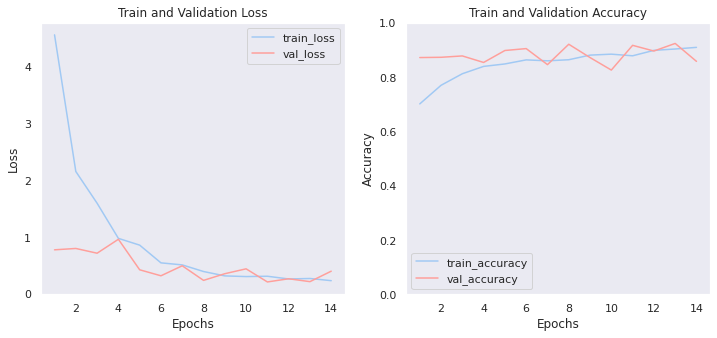

In [42]:
# 학습결과 확인
show_history(history2)

In [47]:
# history 2개 비교 함수
def compare_history(history, history2):
    history_dict = history.history
    history2_dict = history2.history

    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    second_loss = history2_dict['loss']
    second_val_loss = history2_dict['val_loss']
    
    accuracy = history_dict['binary_accuracy']
    val_accuracy = history_dict['val_binary_accuracy']
    second_accuracy = history2_dict['binary_accuracy']
    second_val_accuracy = history2_dict['val_binary_accuracy']

    epochs = range(len(accuracy))
    
    fig = plt.figure(figsize=(12, 5))

    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(epochs, second_loss[:len(epochs)], 'b-', label='model2 train_loss')
    ax1.plot(epochs, second_val_loss[:len(epochs)], 'r-', label='model2 val_loss')
    ax1.plot(epochs, loss[:len(epochs)], 'b--', label='model1 train_loss')
    ax1.plot(epochs, val_loss[:len(epochs)], 'r--', label='model1 val_loss')

    ax1.set_ylim(min(min(loss), min(second_loss)), max(max(loss), max(second_loss)))
    ax1.set_title('Train and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.grid()
    ax1.legend()

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(epochs, second_accuracy[:len(epochs)], 'b-', label='model2 train_accuracy')
    ax2.plot(epochs, second_val_accuracy[:len(epochs)], 'r-', label='model2 val_accuracy')
    ax2.plot(epochs, accuracy[:len(epochs)], 'b--', label='model1 train_accuracy')
    ax2.plot(epochs, val_accuracy[:len(epochs)], 'r--', label='model1 val_accuracy')

    # Set y-axis limits for accuracy plots
    ax2.set_ylim(0, 1)
    
    ax2.set_title('Train and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.grid()
    ax2.legend()

    plt.show()

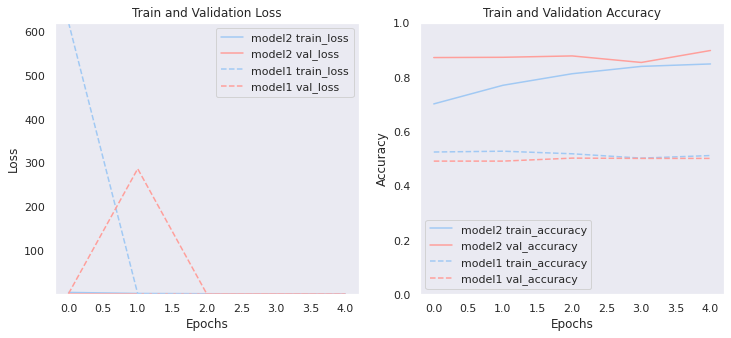

In [46]:
compare_history(history, history2)

- 처음 전혀 학습이 되지 않았는데, 정확도가 70% 정도까지 오르고, 에포크 5부터는 거의 90%정도로 확실히 학습된걸 볼수 있다.